# 0. Import library

In [2]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

pd.options.display.float_format = "{:,.2f}".format

import warnings;
warnings.filterwarnings('ignore')

In [3]:
# nlp tools
import string
import nltk
#nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.corpus import stopwords
import re

from wordcloud import WordCloud

In [4]:
# modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 1. Import data and sampling

In [5]:
df = pd.read_csv('scraped_data_559k.csv')

In [6]:
df.head()

,recommendationid,review,timestamp_created,voted_up
0,132354840,"Loe, love, LOVE this game.\n\nI purchased it w...",1675747403,True
1,132354525,shouldve been more,1675746707,False
2,132354176,It's fun,1675745970,True
3,132353890,full gen z game.,1675745336,False
4,132353500,it good that is all,1675744599,True


In [7]:
df['voted_up'].value_counts(), df['voted_up'].value_counts(normalize = True)

(True     385474
 False    173649
 Name: voted_up, dtype: int64,
 True    0.69
 False   0.31
 Name: voted_up, dtype: float64)

**Create stratified sample for testing**

In [8]:
df_sample = df.groupby('voted_up', group_keys=False).apply(lambda x: x.sample(frac=0.025))
df_sample.reset_index(inplace=True)

In [9]:
df_sample['voted_up'].value_counts(), df_sample['voted_up'].value_counts(normalize = True)

(True     9637
 False    4341
 Name: voted_up, dtype: int64,
 True    0.69
 False   0.31
 Name: voted_up, dtype: float64)

In [10]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13978 entries, 0 to 13977
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              13978 non-null  int64 
 1   recommendationid   13978 non-null  int64 
 2   review             13942 non-null  object
 3   timestamp_created  13978 non-null  int64 
 4   voted_up           13978 non-null  bool  
dtypes: bool(1), int64(3), object(1)
memory usage: 450.6+ KB


In [11]:
df.describe()

,recommendationid,timestamp_created
count,"559,123.00","559,123.00"
mean,"105,526,933.81","1,639,829,794.61"
std,"19,283,021.77","26,610,029.59"
min,"67,288,343.00","1,586,863,659.00"
25%,"83,010,044.50","1,608,779,592.50"
50%,"106,066,902.00","1,639,866,963.00"
75%,"125,120,021.00","1,667,851,473.00"
max,"132,361,652.00","1,675,761,921.00"


# 2. Data Cleaning

In [12]:
df_sample.head()

,index,recommendationid,review,timestamp_created,voted_up
0,369021,128073282,Do not recommend buying until they fix all the...,1670373405,False
1,503129,80967961,"BORING, AVOID",1606611058,False
2,268984,110389850,COD Warzone reskin,1645055280,False
3,311385,103285824,Missing tons of content. Buggy. Feels like the...,1637604518,False
4,453499,124856391,6 crash to desktops so far... only a few level...,1667435083,False


### 2.1 Remove nulls and duplicates

**Drop nulls**

In [13]:
df_sample['review'].isna().value_counts()

False    13942
True        36
Name: review, dtype: int64

In [14]:
df_sample.dropna(subset='review', inplace=True)

In [15]:
df_sample['review'].isna().value_counts()

False    13942
Name: review, dtype: int64

**Drop duplicates**

In [16]:
df_sample['review'].duplicated().value_counts()

False    12662
True      1280
Name: review, dtype: int64

In [17]:
df_sample[df_sample['review'].duplicated()]

,index,recommendationid,review,timestamp_created,voted_up
162,275476,108099486,trash,1642292784,False
236,316483,103182022,bad,1637465881,False
408,551018,105722176,trash,1639332570,False
509,31829,122301535,meh,1663290579,False
565,318741,103149931,bad,1637428778,False
...,...,...,...,...,...
13954,428129,125563788,it good,1668591366,True
13957,530567,118890555,2,1657954603,True
13964,401948,126262102,yep,1669196636,True
13970,523818,126217874,Good,1669186380,True


In [18]:
df_sample.drop_duplicates(subset='review', keep='first', inplace=True)

In [19]:
df_sample['review'].duplicated().value_counts()

False    12662
Name: review, dtype: int64

### 2.2 Pipeline to remove stopwords, punctuation and formatting

**View sample data**

In [20]:
' '.join(df['review'][1:20])

'shouldve been more It\'s fun full gen z game. it good that is all Captivating like a movie adorei, ótimo jogo. uma pena que não teve um lançamento apropriado. It\'s fun. Pretty good. it\'s got its flaws but I have only had this game a week and played 40 hours. as is the case with GTA 5 if its a good game the bugs don\'t bother people. I would say the game compensates with great story and just over all enjoyment factor. my opinion if you like games like this and got cash to spare buy it and see where it takes you. My favourite part is when Keanu Reeves said "It\'s cybering time!" and then Cybered all over those guys Awesome\n This game has been a lot of fun to play and I will definitely be playing it again. I\'m coming in to this game a good 2 years or so after it released, but nonetheless it\'s definitely worth it to buy on sale and enjoy some hours running around Night City doing various shenanigans. It\'s alright. Sorta like mcdonald\'s don\'t expect too much depth but it has style 

**Remove formatting**

[h1] [/h1] [b] etc 

In [21]:
test_sentence = "[h1]It's a great story stories[/h1].\nYou'll need needs a [h2]balling PC[/h2]. It'll you'd won't isn't :'( $$$$ ...... GREATEST. GAME. EVER!!!!!@!&#^%*@!#. [spoiler]Virility[/spoiler] It stands stand for anything[/i][/b] скайрим 看看cdpr干的破事儿 Theyll youd wont isnt"

In [22]:
def remove_markdown(input_string):
    input_string = str(input_string)
    result = re.sub(r'\[.*?\]', '', input_string)
    return result

In [23]:
test_remove_markdown = remove_markdown(test_sentence)
test_remove_markdown

"It's a great story stories.\nYou'll need needs a balling PC. It'll you'd won't isn't :'( $$$$ ...... GREATEST. GAME. EVER!!!!!@!&#^%*@!#. Virility It stands stand for anything скайрим 看看cdpr干的破事儿 Theyll youd wont isnt"

**Remove punctuations**

In [24]:
def remove_puns(input_string):
    result = [letter for letter in input_string if letter not in string.punctuation]
    result = ''.join(result)
    result = ' '.join(result.split()) #replace multiple spaces with single space
    return result

In [25]:
test_remove_puns = remove_puns(test_remove_markdown)
test_remove_puns

'Its a great story stories Youll need needs a balling PC Itll youd wont isnt GREATEST GAME EVER Virility It stands stand for anything скайрим 看看cdpr干的破事儿 Theyll youd wont isnt'

**Remove stopwords**

In [26]:
# create a custom stopwords list that include missing ' like wont, theyll, ive, etc
stopwords_default = stopwords.words('english')
stopwords_custom = [''.join(stopword.split('\'')) for stopword in stopwords_default] + ['theyll', 'theyd','theyre', 'woulda','wouldve','ive','imma','itll', 'youll']
stopwords_merged = set(stopwords_default).union(set(stopwords_custom))

In [27]:
def remove_stopwords(input_string):
    input_words = input_string.split(' ')
    result = [word for word in input_words if word.lower() not in stopwords_merged] 
    # don't call stopwords.words('english') in a loop, take 100x time to finish
    # assign it to a list object in memory instead

    result = ' '.join(result) # disable if need to return list
    return result

In [28]:
test_remove_stopwords = remove_stopwords(test_remove_puns)
test_remove_stopwords

'great story stories need needs balling PC GREATEST GAME EVER Virility stands stand anything скайрим 看看cdpr干的破事儿'

**Remove non latin character**

In [29]:
from nltk.tokenize import RegexpTokenizer
def remove_non_latin(input_string):
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    return tokenizer.tokenize(input_string.lower())

In [30]:
test_remove_nonlatin = remove_non_latin(test_remove_stopwords)
test_remove_nonlatin

['great',
 'story',
 'stories',
 'need',
 'needs',
 'balling',
 'pc',
 'greatest',
 'game',
 'ever',
 'virility',
 'stands',
 'stand',
 'anything',
 'cdpr']

**Lemmatizing**

In [31]:
def lemmatize(input_list):
    lemmatizer = WordNetLemmatizer()
    result = list(map(lemmatizer.lemmatize, input_list))
    return result

In [32]:
test_lemmatize = lemmatize(test_remove_nonlatin)
test_lemmatize

['great',
 'story',
 'story',
 'need',
 'need',
 'balling',
 'pc',
 'greatest',
 'game',
 'ever',
 'virility',
 'stand',
 'stand',
 'anything',
 'cdpr']

**Make pipeline**

In [232]:
def review_cleaning(input_string):
    result = remove_markdown(input_string)
    result = remove_puns(result)
    result = remove_stopwords(result)
    result = remove_non_latin(result)
    result = lemmatize(result)
    result = ' '.join(result)

    return result

## 3. EDA

In [37]:
X = df_sample['review'].apply(review_cleaning)
y = df_sample.voted_up

### 3.1 WordCloud

Positive review

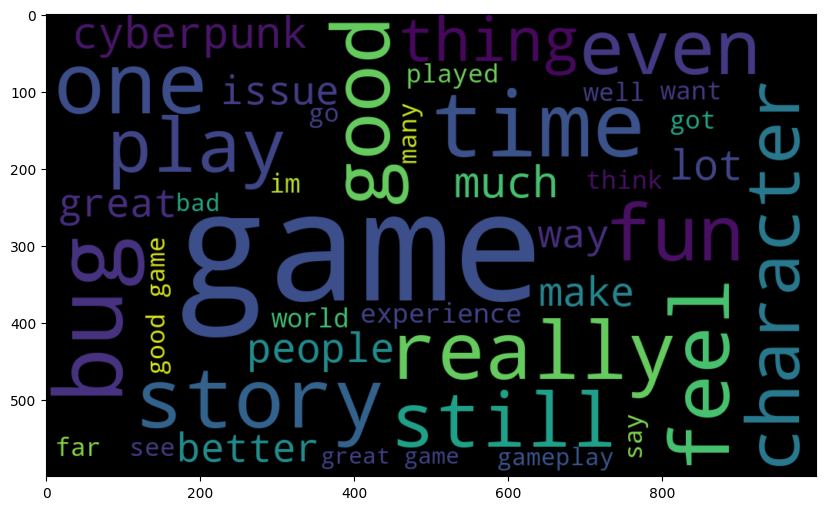

In [40]:
vote_up_cleaned = ' '.join(X[y])
plt.figure(figsize=(10,6))
wordcloud = WordCloud(background_color = 'black', 
                      max_font_size = 200, 
                      max_words = 40, 
                      width = 1000, height = 600
                     ).generate(vote_up_cleaned)
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.show()

Negative review

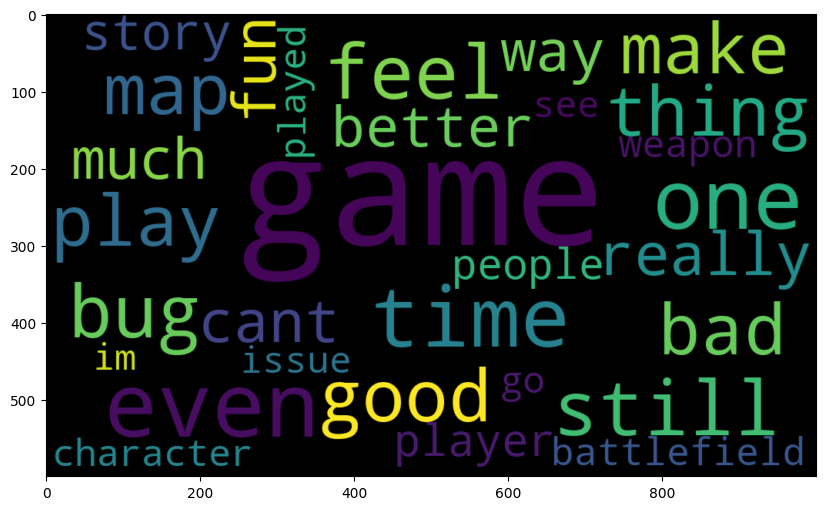

In [41]:
vote_down_cleaned = ' '.join(X[~y])

plt.figure(figsize=(10,6))
wordcloud = WordCloud(background_color = 'black', 
                      max_font_size = 200, 
                      max_words = 30, 
                      width = 1000, height = 600
                     ).generate(vote_down_cleaned)
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.show()

### 3.2 Frequency distribution

**Word counts:**

In [57]:
df_visualize = X.to_frame()

df_visualize['word_counts'] = df_visualize['review'].apply(lambda x: x.split(' ')).apply(len)
df_visualize['voted_up'] = df_sample['voted_up']

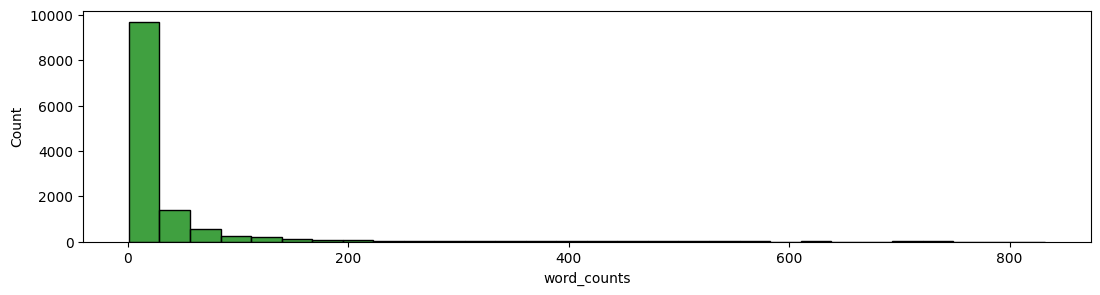

In [66]:
plt.figure(figsize=(13,3))
sns.histplot(data=df_visualize, x="word_counts",bins=30,color='green')

plt.show()

**Unique words:**

In [67]:
review_text_all = []
for review in df_visualize['review']:
    review_text_all +=review
f'Unique words: {len(set(review_text_all))}'

'Unique words: 37'

In [72]:
%%time
review_text_all = []
for review in df_visualize['review'].apply(lambda x: x.split(' ')):
    review_text_all +=review
f'Unique words: {len(set(review_text_all))}'

CPU times: total: 15.6 ms
Wall time: 68.7 ms


'Unique words: 21339'

**Positive / negative review text**

In [76]:
review_text_positive = []
for review in df_visualize['review'][df_visualize['voted_up']].apply(lambda x: x.split(' ')):
    review_text_positive +=review    
top_20_positive = pd.Series(review_text_positive).value_counts().head(20)
top_20_positive

game         10395
bug           2225
good          2215
like          2180
story         1887
fun           1816
great         1440
get           1374
really        1366
time          1362
play          1331
still         1219
one           1180
lot           1048
feel          1020
character      953
would          921
even           886
im             846
much           844
dtype: int64

In [77]:
review_text_negative = []
for review in df_visualize['review'][~df_visualize['voted_up']].apply(lambda x: x.split(' ')):
    review_text_negative +=review
top_20_negative = pd.Series(review_text_negative).value_counts().head(20)
top_20_negative

game           7580
like           1578
get            1200
play           1153
even           1139
time           1080
bug             894
crash           860
good            833
still           830
feel            783
one             783
cant            703
would           679
make            644
battlefield     632
really          618
story           592
bad             579
map             573
dtype: int64

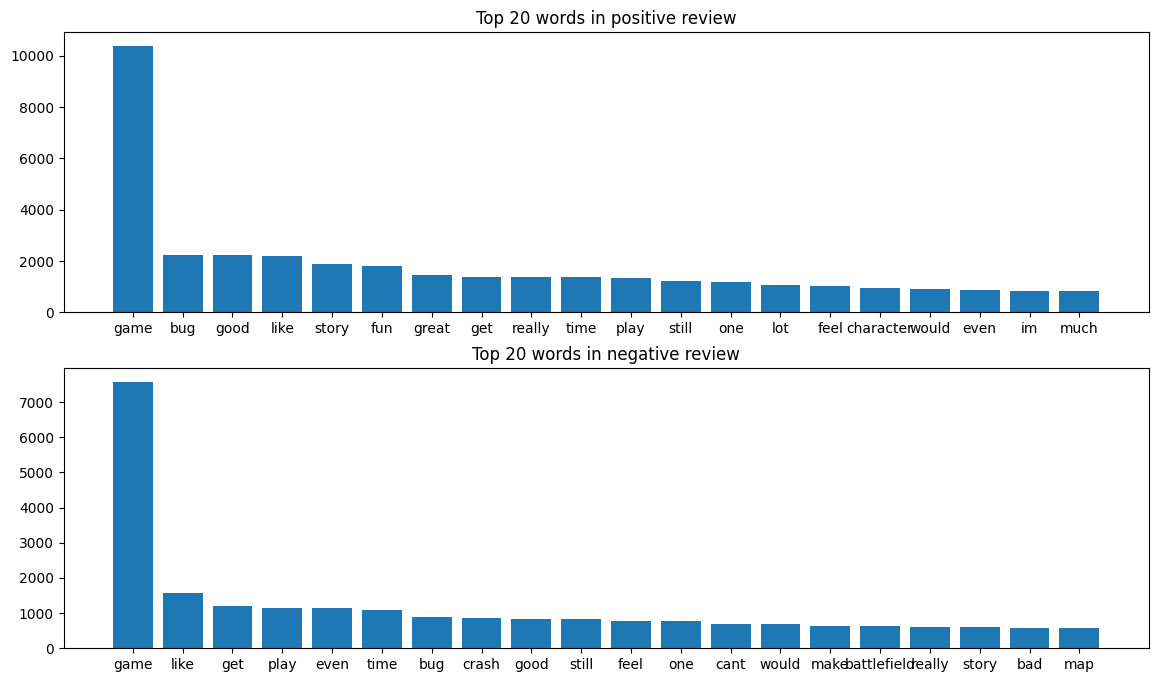

In [78]:
fig = plt.figure(figsize=(14,8))  
ax1 = fig.add_subplot(211)   
ax2 = fig.add_subplot(212) 

ax1.bar(top_20_positive.index, top_20_positive)
ax1.set_title('Top 20 words in positive review')

ax2.bar(top_20_negative.index, top_20_negative)
ax2.set_title('Top 20 words in negative review')
plt.show()

# 4. Preprocess

In [80]:
%%time
# features
X = df_sample['review'].apply(review_cleaning)

# target
y = df_sample.voted_up

X.head()

CPU times: total: 1.34 s
Wall time: 1.75 s


0    recommend buying fix crap wrong random crash r...
1                                         boring avoid
2                                   cod warzone reskin
3    missing ton content buggy feel like shell game...
4                            6 crash desktop far level
Name: review, dtype: object

### Bag of words

In [103]:
def bow_vectorizer(X_train, X_test, n_features):
    vectorizer = CountVectorizer(max_features = n_features, dtype = np.uint8)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())
    return X_train, X_test

### TF IDF

In [102]:
def tfidf_vectorizer(X_train, X_test, n_features):
    vectorizer = TfidfVectorizer(max_features = n_features)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())

    return X_train, X_test

### TF IDF with bigram

In [104]:
def tfidf2g_vectorizer(X_train, X_test, n_features):
    vectorizer = TfidfVectorizer(max_features = n_features, ngram_range=(1,2))
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())

    return X_train, X_test

# 5. Baseline models

## Functions to store test result

In [98]:
columns = ['model name', 'data','time', 
           'train_down_Pre', 'train_down_Rec', 'train_down_F1',
           'train_up_Pre', 'train_up_Rec', 'train_up_F1',
           'train_acc',
           'test_down_Pre', 'test_down_Rec', 'test_down_F1',
           'test_up_Pre', 'test_up_Rec', 'test_up_F1',
           'test_acc']
           
df_metrics = pd.DataFrame(columns = columns)

In [99]:
def reset(df_metrics):
    return pd.DataFrame(columns = columns)

In [100]:
def classifier_performance(model_name, model, data, X_train, X_test, y_train, y_test):
    print(f'Training: {model_name} / {data}')
    start = time.time()
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    complete_time = time.time() - start
    # Train ##############
    # accuracy
    accuracy_train = accuracy_score(y_train, y_hat_train)
    # pre/rec/f1 for True
    precision_train_True = precision_score(y_train, y_hat_train, pos_label = True)
    recall_train_True = recall_score(y_train, y_hat_train, pos_label = True)
    F1_train_True = f1_score(y_train, y_hat_train, pos_label = True)
    
    # pre/rec/f1 for false
    precision_train_False = precision_score(y_train, y_hat_train, pos_label = False)
    recall_train_False = recall_score(y_train, y_hat_train, pos_label = False)
    F1_train_False = f1_score(y_train, y_hat_train, pos_label = False)
    
    # Test ##############
    # accuracy
    accuracy_test = accuracy_score(y_test, y_hat_test)
    # pre/rec/f1 for True
    precision_test_True = precision_score(y_test, y_hat_test, pos_label = True)
    recall_test_True = recall_score(y_test, y_hat_test, pos_label = True)
    F1_test_True = f1_score(y_test, y_hat_test, pos_label = True)

    # pre/rec/f1 for false
    precision_test_False = precision_score(y_test, y_hat_test, pos_label = False)
    recall_test_False = recall_score(y_test, y_hat_test, pos_label = False)
    F1_test_False = f1_score(y_test, y_hat_test, pos_label = False)
    
    # store result
    df_metrics.loc[len(df_metrics.index)] = [
        model_name, data, complete_time, 
        precision_train_False, recall_train_False, F1_train_False,
        precision_train_True,  recall_train_True,  F1_train_True, accuracy_train,
        precision_test_False,  recall_test_False,  F1_test_False, 
        precision_test_True,   recall_test_True,   F1_test_True, accuracy_test]
    
    print(f'Finished in {complete_time:.2f}')
    print('='*50)
    # return df_metrics.loc[len(df_metrics.index)-1]

## Baseline models

In [101]:
NB_classifier = MultinomialNB()
LG_classifier = LogisticRegression(random_state = 14)
RF_classifier = RandomForestClassifier(random_state = 14)
XGB_classifier = xgb.XGBClassifier(objective='binary:logistic', seed=14)

In [123]:
vectorizer_list = [bow_vectorizer, tfidf_vectorizer, tfidf2g_vectorizer]
n_features = [500,800, 1000, 1500, 2000]

models = [('NB_classifier', NB_classifier),
          ('LG_classifier',LG_classifier),
          ('RF_classifier',RF_classifier),
          ('XGB_classifier', XGB_classifier)
         ]


In [124]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=14)

# loop through the range of n_feature
for n_feature in n_features:
    # loop through the vectorizer
    for vectorizer in vectorizer_list:
        X_train_vectorized, X_test_vectorized = vectorizer(X_train, X_test, n_feature)
        # loop through the baseline models
        for model_name, model in models:
            classifier_performance(model_name, model, vectorizer.__name__+str(n_feature), 
                                   X_train_vectorized, X_test_vectorized, y_train, y_test)

Training: NB_classifier / bow_vectorizer500
Finished in 0.05
Training: LG_classifier / bow_vectorizer500
Finished in 0.35
Training: RF_classifier / bow_vectorizer500
Finished in 6.21
Training: XGB_classifier / bow_vectorizer500
[21:44:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Finished in 2.10
Training: NB_classifier / tfidf_vectorizer500
Finished in 0.03
Training: LG_classifier / tfidf_vectorizer500
Finished in 0.22
Training: RF_classifier / tfidf_vectorizer500
Finished in 7.78
Training: XGB_classifier / tfidf_vectorizer500
[21:44:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the ob

In [137]:
summary = ['model name', 'data', 'time', 'train_acc','test_acc', 'train_up_F1', 'test_up_F1','train_down_F1', 'test_down_F1']
summary2 = ['model name', 'data', 'time', 'train_acc','test_acc', 'test_up_F1','test_down_F1']

df_metrics[summary2]

,model name,data,time,train_acc,test_acc,test_up_F1,test_down_F1
0,NB_classifier,bow_vectorizer500,0.05,0.82,0.82,0.87,0.69
1,LG_classifier,bow_vectorizer500,0.35,0.84,0.82,0.87,0.69
2,RF_classifier,bow_vectorizer500,6.21,0.96,0.81,0.86,0.69
3,XGB_classifier,bow_vectorizer500,2.10,0.89,0.82,0.87,0.69
4,NB_classifier,tfidf_vectorizer500,0.03,0.82,0.81,0.87,0.64
5,LG_classifier,tfidf_vectorizer500,0.22,0.84,0.83,0.88,0.70
6,RF_classifier,tfidf_vectorizer500,7.78,0.96,0.81,0.86,0.68
7,XGB_classifier,tfidf_vectorizer500,2.39,0.90,0.81,0.87,0.67
8,NB_classifier,tfidf2g_vectorizer500,0.03,0.82,0.82,0.87,0.66
9,LG_classifier,tfidf2g_vectorizer500,0.24,0.84,0.83,0.88,0.71


## Visualize metrics summary

In [154]:
df_metrics['preprocessed'] = df_metrics.data.str.split('_').apply(lambda x: x[0])
df_metrics['feature_size'] = df_metrics.data.str.split('_').apply(lambda x: x[-1][10:])

df_metrics_nonDL = df_metrics.copy()

### Accuracy on test set, by model (and by preprocess, and by feature size)

<Axes: xlabel='model name', ylabel='test_acc'>

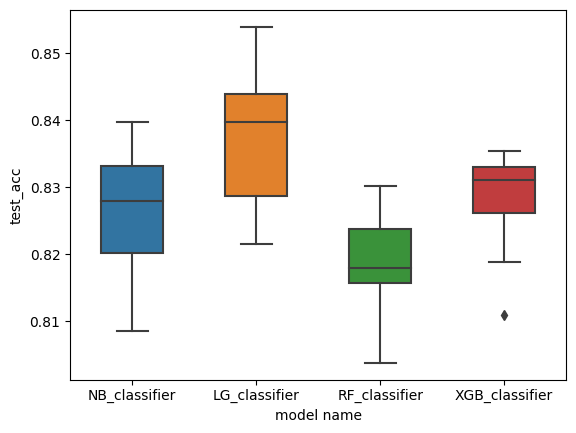

In [148]:
# test accuracy by model
sns.boxplot(data=df_metrics, x='model name', y='test_acc',width=0.5)

<Axes: xlabel='model name', ylabel='test_acc'>

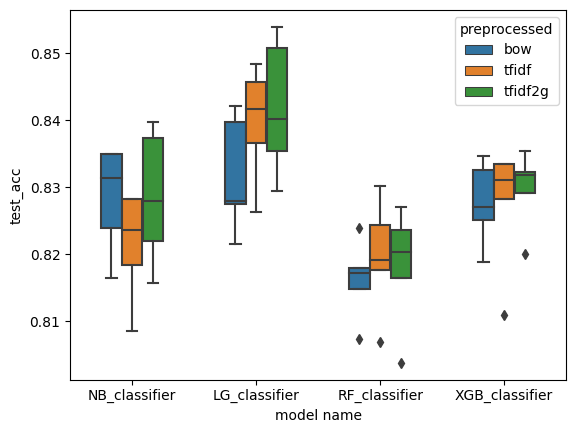

In [155]:
# test accuracy by model and preprocessed
sns.boxplot(data=df_metrics, x='model name', y='test_acc', hue = 'preprocessed', width=0.5)

<Axes: xlabel='model name', ylabel='test_acc'>

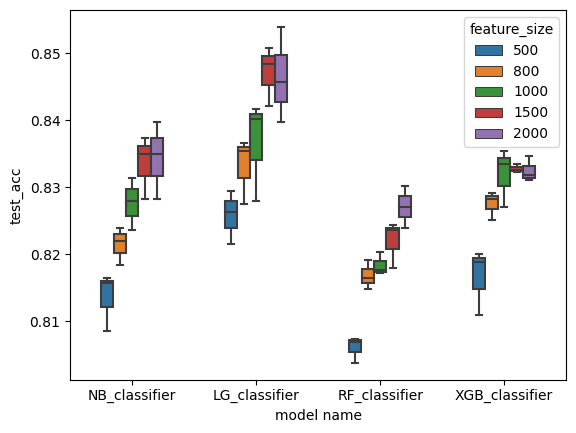

In [150]:
# test accuracy by model and feature size
sns.boxplot(data=df_metrics, x='model name', y='test_acc', hue = 'feature_size', width=0.5)

### F1 on test set, by model

<Axes: xlabel='model name', ylabel='test_down_F1'>

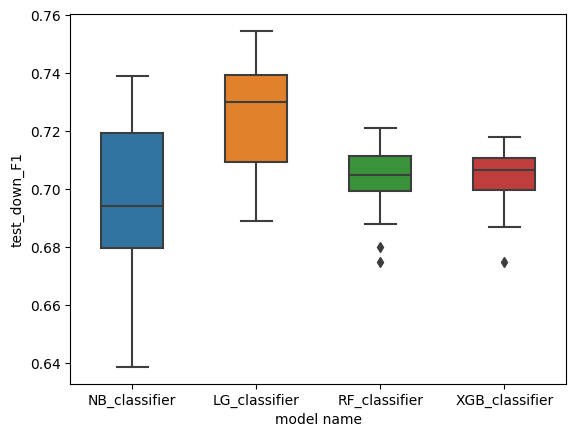

In [156]:
# test accuracy by model
sns.boxplot(data=df_metrics, x='model name', y='test_down_F1',width=0.5)

### F1 score for negative on test set, by model AND preprocess

<Axes: xlabel='model name', ylabel='test_down_F1'>

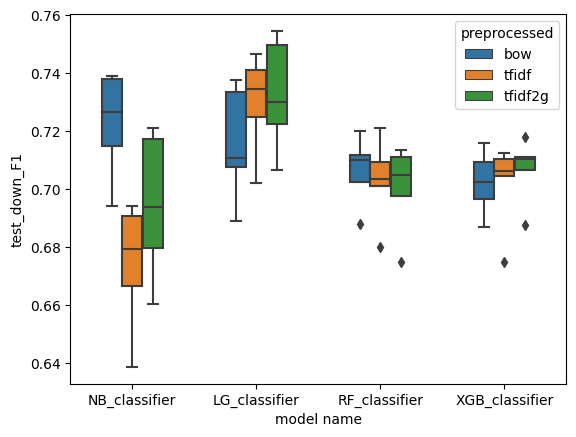

In [157]:
# test f1 (vote down) by model and preprocessed
sns.boxplot(data=df_metrics, x='model name', y='test_down_F1', hue='preprocessed', width=0.5)

### F1 score for negative on test set, by model AND feature size

<Axes: xlabel='model name', ylabel='test_down_F1'>

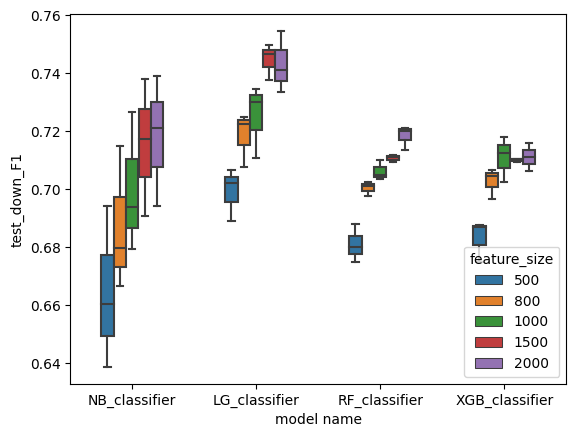

In [158]:
sns.boxplot(data=df_metrics, x='model name', y='test_down_F1', hue='feature_size', width=0.5)

### Conclusion

- Logistic regression have overall best performance in term of accuracy and F1 score.
- The baseline RF model and XGB model's performance could have improved if they were assigned class weights, due to balance imbalance.
- Having higher amount of features works for RF since it can handle high-dimensional data better , but not necessarily for logistic regression.
- In term of feature engineering techniques, TFIDF with bigram are somewhat better than the other 2.

# 6. Baseline DL models

In [159]:
# deep learning algo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import backend
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Fixing the seed for random number generators
tf.random.set_seed(42)

# keras tuner
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

### Function to store metrics

In [221]:
def dl_performance(model_name, dlmodel, X_name, X_train, X_test, y_train, y_test, complete_time = 0, threshold = 0.5):
    
    #print('Training: ', model_name, '/', X_name)
    y_hat_train = np.where(dlmodel.predict(X_train) > threshold,1,0)
    y_hat_test = np.where(dlmodel.predict(X_test) > threshold,1,0)
    
    
    # Train ##############
    # accuracy
    accuracy_train = accuracy_score(y_train, y_hat_train)
    # pre/rec/f1 for True
    precision_train_True = precision_score(y_train, y_hat_train, pos_label = True)
    recall_train_True = recall_score(y_train, y_hat_train, pos_label = True)
    F1_train_True = f1_score(y_train, y_hat_train, pos_label = True)
    
    # pre/rec/f1 for false
    precision_train_False = precision_score(y_train, y_hat_train, pos_label = False)
    recall_train_False = recall_score(y_train, y_hat_train, pos_label = False)
    F1_train_False = f1_score(y_train, y_hat_train, pos_label = False)
    
    # Test ##############
    # accuracy
    accuracy_test = accuracy_score(y_test, y_hat_test)
    # pre/rec/f1 for True
    precision_test_True = precision_score(y_test, y_hat_test, pos_label = True)
    recall_test_True = recall_score(y_test, y_hat_test, pos_label = True)
    F1_test_True = f1_score(y_test, y_hat_test, pos_label = True)

    # pre/rec/f1 for false
    precision_test_False = precision_score(y_test, y_hat_test, pos_label = False)
    recall_test_False = recall_score(y_test, y_hat_test, pos_label = False)
    F1_test_False = f1_score(y_test, y_hat_test, pos_label = False)

    # store result
    df_metrics.loc[len(df_metrics.index)] = [
        model_name, X_name, complete_time, 
        precision_train_False, recall_train_False, F1_train_False,
        precision_train_True,  recall_train_True,  F1_train_True, accuracy_train,
        precision_test_False,  recall_test_False,  F1_test_False, 
        precision_test_True,   recall_test_True,   F1_test_True, accuracy_test]
    print('Finished in',complete_time)
    print('='*50)
    return df_metrics.loc[len(df_metrics.index)-1]

In [229]:
def accuracy_vs_epochs(history, from_epoc=0):
    df_history = pd.DataFrame(history.history).iloc[from_epoc:]
    plt.figure(figsize = (4,2))
    plt.plot(df_history.iloc[:,1])
    plt.plot(df_history.iloc[:,3])
    plt.xlim(left=-1)
    plt.title(str(df_history.columns[1]) +  ' vs epochs')
    plt.ylabel(df_history.columns[1])
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

### DL model

In [225]:
# function to create DL model
def make_DL_model(neuron_list, dropout_list, input_dim, metric='AUC'):
    
    model = Sequential()
    model.add(Dense(neuron_list[0], activation='relu',kernel_initializer='he_uniform',input_dim = input_dim))
    model.add(Dropout(dropout_list[0]))
    
    for neuron, dropout in zip(neuron_list[1:], dropout_list[1:]):
        model.add(Dense(neuron,activation='relu',kernel_initializer='he_uniform'))
        model.add(Dropout(dropout))
   
    # Output layer
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.001), metrics=metric)
    return model

In [171]:
# early stopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

### Loops

In [230]:
df_metrics = reset(df_metrics)

Training:  DL_3layers / bow_vectorizer500
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5661 - auc: 0.7315 - val_loss: 0.4700 - val_auc: 0.8529
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4370 - auc: 0.8595 - val_loss: 0.4334 - val_auc: 0.8622
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3878 - auc: 0.8857 - val_loss: 0.4355 - val_auc: 0.8615
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3586 - auc: 0.9029 - val_loss: 0.4361 - val_auc: 0.8609
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3334 - auc: 0.9160 - val_loss: 0.4571 - val_auc: 0.8571
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3135 - auc: 0.9260 - val_loss: 0.4639 - val_auc: 0.8580
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2918 - auc: 0.9360 - val_loss: 0.4742 - val_auc: 0.8544


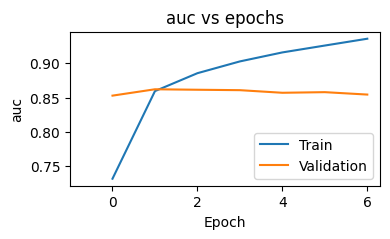

80/80 [==============================] - 0s 873us/step
Finished in 0
Training:  DL_4layers / bow_vectorizer500
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.6053 - auc: 0.6798 - val_loss: 0.4912 - val_auc: 0.8342
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4628 - auc: 0.8420 - val_loss: 0.4483 - val_auc: 0.8539
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.4032 - auc: 0.8792 - val_loss: 0.4458 - val_auc: 0.8525
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3772 - auc: 0.8961 - val_loss: 0.4513 - val_auc: 0.8510
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3475 - auc: 0.9102 - val_loss: 0.4764 - val_auc: 0.8490
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3220 - auc: 0.9213 - val_loss: 0.4957 - val_auc: 0.8436
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2925 - auc: 0.9349 - 

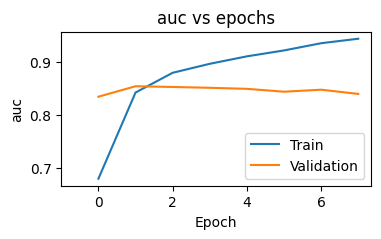

80/80 [==============================] - 0s 994us/step
Finished in 0
Training:  DL_3layers / tfidf_vectorizer500
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5339 - auc: 0.7566 - val_loss: 0.4417 - val_auc: 0.8576
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3992 - auc: 0.8794 - val_loss: 0.4224 - val_auc: 0.8646
Epoch 3/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3660 - auc: 0.8991 - val_loss: 0.4314 - val_auc: 0.8625
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3495 - auc: 0.9076 - val_loss: 0.4388 - val_auc: 0.8584
Epoch 5/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3291 - auc: 0.9184 - val_loss: 0.4560 - val_auc: 0.8585
Epoch 6/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3113 - auc: 0.9251 - val_loss: 0.4706 - val_auc: 0.8542
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2858 - auc: 0.9367 

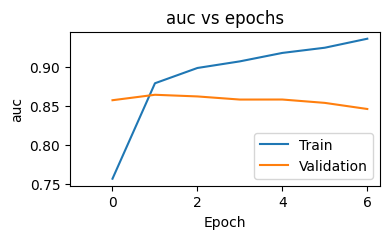

80/80 [==============================] - 0s 848us/step
Finished in 0
Training:  DL_4layers / tfidf_vectorizer500
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5363 - auc: 0.7575 - val_loss: 0.4505 - val_auc: 0.8559
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4089 - auc: 0.8741 - val_loss: 0.4256 - val_auc: 0.8615
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3681 - auc: 0.8985 - val_loss: 0.4327 - val_auc: 0.8594
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3437 - auc: 0.9119 - val_loss: 0.4408 - val_auc: 0.8545
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3240 - auc: 0.9213 - val_loss: 0.4498 - val_auc: 0.8518
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2968 - auc: 0.9337 - val_loss: 0.4779 - val_auc: 0.8503
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2630 - auc: 0.9482 

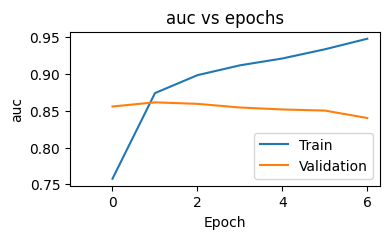

80/80 [==============================] - 0s 885us/step
Finished in 0
Training:  DL_3layers / tfidf2g_vectorizer500
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5263 - auc: 0.7698 - val_loss: 0.4533 - val_auc: 0.8520
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4051 - auc: 0.8765 - val_loss: 0.4340 - val_auc: 0.8570
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3701 - auc: 0.8958 - val_loss: 0.4475 - val_auc: 0.8494
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3497 - auc: 0.9069 - val_loss: 0.4535 - val_auc: 0.8477
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3319 - auc: 0.9169 - val_loss: 0.4684 - val_auc: 0.8467
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3112 - auc: 0.9252 - val_loss: 0.4745 - val_auc: 0.8449
Epoch 7/10
285/285 [==============================] - 0s 2ms/step - loss: 0.2903 - auc: 0.936

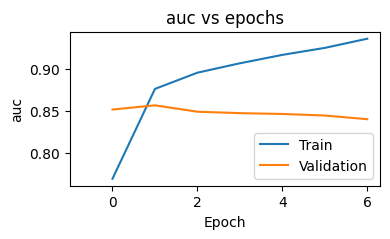

80/80 [==============================] - 0s 829us/step
Finished in 0
Training:  DL_4layers / tfidf2g_vectorizer500
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5345 - auc: 0.7551 - val_loss: 0.4459 - val_auc: 0.8515
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4074 - auc: 0.8727 - val_loss: 0.4504 - val_auc: 0.8522
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3764 - auc: 0.8926 - val_loss: 0.4367 - val_auc: 0.8547
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3495 - auc: 0.9072 - val_loss: 0.4431 - val_auc: 0.8493
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3251 - auc: 0.9194 - val_loss: 0.4749 - val_auc: 0.8493
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2975 - auc: 0.9315 - val_loss: 0.4865 - val_auc: 0.8426
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2693 - auc: 0.944

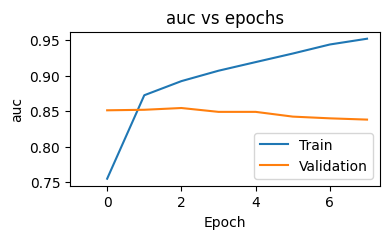

80/80 [==============================] - 0s 955us/step
Finished in 0
Training:  DL_3layers / bow_vectorizer800
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5525 - auc: 0.7502 - val_loss: 0.4520 - val_auc: 0.8518
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4122 - auc: 0.8824 - val_loss: 0.4403 - val_auc: 0.8629
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3528 - auc: 0.9087 - val_loss: 0.4360 - val_auc: 0.8675
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3225 - auc: 0.9230 - val_loss: 0.4517 - val_auc: 0.8631
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2906 - auc: 0.9374 - val_loss: 0.4755 - val_auc: 0.8649
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2702 - auc: 0.9457 - val_loss: 0.4777 - val_auc: 0.8644
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2516 - auc: 0.9541 - 

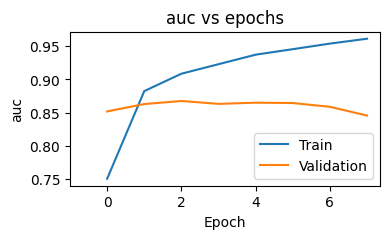

80/80 [==============================] - 0s 898us/step
Finished in 0
Training:  DL_4layers / bow_vectorizer800
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5960 - auc: 0.6980 - val_loss: 0.4604 - val_auc: 0.8515
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.4301 - auc: 0.8669 - val_loss: 0.4225 - val_auc: 0.8697
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3641 - auc: 0.9022 - val_loss: 0.4267 - val_auc: 0.8717
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3308 - auc: 0.9192 - val_loss: 0.4366 - val_auc: 0.8685
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2960 - auc: 0.9339 - val_loss: 0.4718 - val_auc: 0.8643
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2671 - auc: 0.9463 - val_loss: 0.4755 - val_auc: 0.8605
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2322 - auc: 0.9585 - 

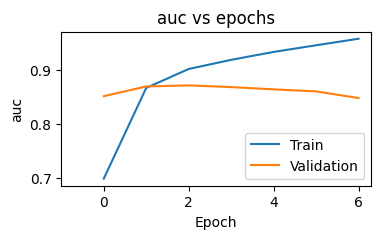

80/80 [==============================] - 0s 1ms/step
Finished in 0
Training:  DL_3layers / tfidf_vectorizer800
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5133 - auc: 0.7816 - val_loss: 0.4179 - val_auc: 0.8719
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3701 - auc: 0.8977 - val_loss: 0.4072 - val_auc: 0.8738
Epoch 3/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3389 - auc: 0.9147 - val_loss: 0.4136 - val_auc: 0.8741
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3076 - auc: 0.9292 - val_loss: 0.4315 - val_auc: 0.8712
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2766 - auc: 0.9418 - val_loss: 0.4508 - val_auc: 0.8680
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2499 - auc: 0.9518 - val_loss: 0.4809 - val_auc: 0.8655
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2209 - auc: 0.9617 - 

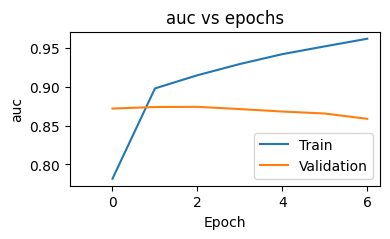

80/80 [==============================] - 0s 911us/step
Finished in 0
Training:  DL_4layers / tfidf_vectorizer800
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5207 - auc: 0.7782 - val_loss: 0.4224 - val_auc: 0.8711
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3800 - auc: 0.8908 - val_loss: 0.4141 - val_auc: 0.8701
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3343 - auc: 0.9164 - val_loss: 0.4181 - val_auc: 0.8728
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3022 - auc: 0.9325 - val_loss: 0.4488 - val_auc: 0.8623
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2646 - auc: 0.9472 - val_loss: 0.4659 - val_auc: 0.8613
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2341 - auc: 0.9571 - val_loss: 0.5351 - val_auc: 0.8513
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.1995 - auc: 0.9688 

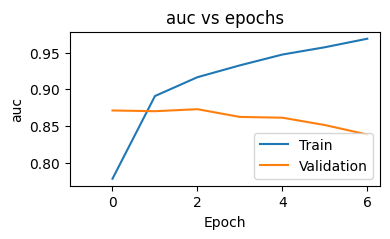

80/80 [==============================] - 0s 943us/step
Finished in 0
Training:  DL_3layers / tfidf2g_vectorizer800
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5055 - auc: 0.7923 - val_loss: 0.4276 - val_auc: 0.8669
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3697 - auc: 0.8975 - val_loss: 0.4192 - val_auc: 0.8719
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3326 - auc: 0.9174 - val_loss: 0.4315 - val_auc: 0.8639
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3081 - auc: 0.9284 - val_loss: 0.4463 - val_auc: 0.8609
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2757 - auc: 0.9423 - val_loss: 0.4843 - val_auc: 0.8557
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2501 - auc: 0.9526 - val_loss: 0.5108 - val_auc: 0.8521
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2319 - auc: 0.958

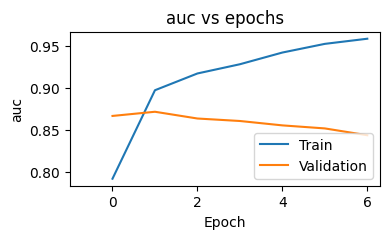

80/80 [==============================] - 0s 861us/step
Finished in 0
Training:  DL_4layers / tfidf2g_vectorizer800
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.5198 - auc: 0.7762 - val_loss: 0.4451 - val_auc: 0.8629
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3787 - auc: 0.8930 - val_loss: 0.4205 - val_auc: 0.8690
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3376 - auc: 0.9154 - val_loss: 0.4283 - val_auc: 0.8650
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2985 - auc: 0.9331 - val_loss: 0.4636 - val_auc: 0.8545
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2682 - auc: 0.9458 - val_loss: 0.4800 - val_auc: 0.8542
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2340 - auc: 0.9568 - val_loss: 0.5378 - val_auc: 0.8498
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2056 - auc: 0.967

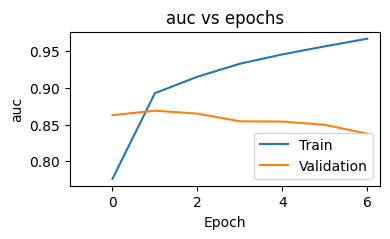

80/80 [==============================] - 0s 1000us/step
Finished in 0
Training:  DL_3layers / bow_vectorizer1000
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5466 - auc: 0.7636 - val_loss: 0.4294 - val_auc: 0.8730
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3929 - auc: 0.8886 - val_loss: 0.4066 - val_auc: 0.8801
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3351 - auc: 0.9175 - val_loss: 0.4152 - val_auc: 0.8777
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3010 - auc: 0.9326 - val_loss: 0.4448 - val_auc: 0.8729
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2686 - auc: 0.9462 - val_loss: 0.4561 - val_auc: 0.8718
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2366 - auc: 0.9578 - val_loss: 0.4875 - val_auc: 0.8706
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2191 - auc: 0.9640 

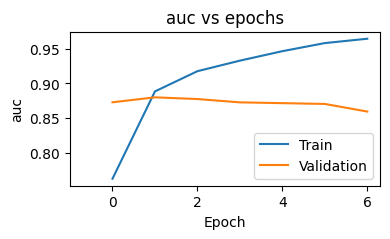

80/80 [==============================] - 0s 949us/step
Finished in 0
Training:  DL_4layers / bow_vectorizer1000
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.5793 - auc: 0.7143 - val_loss: 0.4637 - val_auc: 0.8584
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.4106 - auc: 0.8777 - val_loss: 0.4190 - val_auc: 0.8747
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3442 - auc: 0.9134 - val_loss: 0.4362 - val_auc: 0.8706
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3095 - auc: 0.9288 - val_loss: 0.4518 - val_auc: 0.8709
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2693 - auc: 0.9466 - val_loss: 0.4598 - val_auc: 0.8695
Epoch 6/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2411 - auc: 0.9570 - val_loss: 0.5186 - val_auc: 0.8618
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2120 - auc: 0.9652 -

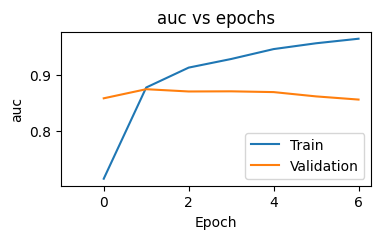

80/80 [==============================] - 0s 1ms/step
Finished in 0
Training:  DL_3layers / tfidf_vectorizer1000
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5135 - auc: 0.7780 - val_loss: 0.4171 - val_auc: 0.8734
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3598 - auc: 0.9041 - val_loss: 0.4062 - val_auc: 0.8774
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3174 - auc: 0.9257 - val_loss: 0.4202 - val_auc: 0.8750
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2894 - auc: 0.9371 - val_loss: 0.4378 - val_auc: 0.8681
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2541 - auc: 0.9514 - val_loss: 0.4699 - val_auc: 0.8685
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2254 - auc: 0.9608 - val_loss: 0.5155 - val_auc: 0.8624
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.1986 - auc: 0.9690 -

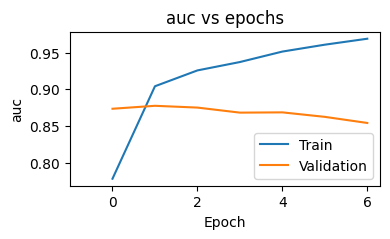

80/80 [==============================] - 0s 911us/step
Finished in 0
Training:  DL_4layers / tfidf_vectorizer1000
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.5156 - auc: 0.7812 - val_loss: 0.4212 - val_auc: 0.8744
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3633 - auc: 0.9039 - val_loss: 0.4021 - val_auc: 0.8811
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3150 - auc: 0.9263 - val_loss: 0.4175 - val_auc: 0.8762
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2771 - auc: 0.9435 - val_loss: 0.4452 - val_auc: 0.8698
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2354 - auc: 0.9579 - val_loss: 0.4778 - val_auc: 0.8656
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2006 - auc: 0.9683 - val_loss: 0.5407 - val_auc: 0.8621
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1760 - auc: 0.9751

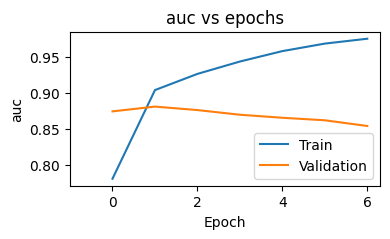

80/80 [==============================] - 0s 2ms/step
Finished in 0
Training:  DL_3layers / tfidf2g_vectorizer1000
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5030 - auc: 0.7955 - val_loss: 0.4273 - val_auc: 0.8731
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3604 - auc: 0.9034 - val_loss: 0.4133 - val_auc: 0.8757
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3119 - auc: 0.9275 - val_loss: 0.4245 - val_auc: 0.8705
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2869 - auc: 0.9393 - val_loss: 0.4452 - val_auc: 0.8669
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2508 - auc: 0.9520 - val_loss: 0.4743 - val_auc: 0.8651
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2196 - auc: 0.9631 - val_loss: 0.5153 - val_auc: 0.8577
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.1985 - auc: 0.9689

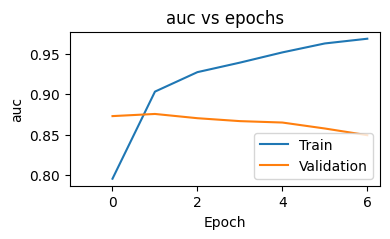

80/80 [==============================] - 0s 917us/step
Finished in 0
Training:  DL_4layers / tfidf2g_vectorizer1000
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.5147 - auc: 0.7796 - val_loss: 0.4142 - val_auc: 0.8758
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3693 - auc: 0.8992 - val_loss: 0.4086 - val_auc: 0.8770
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3174 - auc: 0.9257 - val_loss: 0.4178 - val_auc: 0.8737
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2813 - auc: 0.9424 - val_loss: 0.4597 - val_auc: 0.8634
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2405 - auc: 0.9565 - val_loss: 0.5210 - val_auc: 0.8612
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2081 - auc: 0.9661 - val_loss: 0.5486 - val_auc: 0.8537
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1734 - auc: 0.97

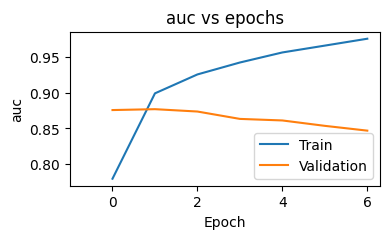

80/80 [==============================] - 0s 987us/step
Finished in 0
Training:  DL_3layers / bow_vectorizer1500
Epoch 1/10
285/285 [==============================] - 3s 7ms/step - loss: 0.5370 - auc: 0.7742 - val_loss: 0.4404 - val_auc: 0.8621
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3724 - auc: 0.8997 - val_loss: 0.4228 - val_auc: 0.8741
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.3092 - auc: 0.9300 - val_loss: 0.4434 - val_auc: 0.8731
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2743 - auc: 0.9446 - val_loss: 0.4517 - val_auc: 0.8745
Epoch 5/10
285/285 [==============================] - 1s 5ms/step - loss: 0.2335 - auc: 0.9593 - val_loss: 0.4879 - val_auc: 0.8691
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2113 - auc: 0.9664 - val_loss: 0.5236 - val_auc: 0.8690
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1902 - auc: 0.9718 -

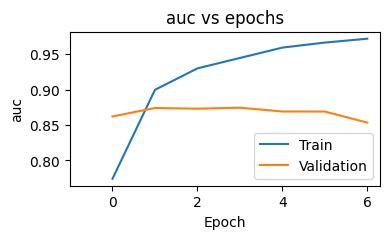

80/80 [==============================] - 0s 3ms/step
Finished in 0
Training:  DL_4layers / bow_vectorizer1500
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.5651 - auc: 0.7385 - val_loss: 0.4301 - val_auc: 0.8727
Epoch 2/10
285/285 [==============================] - 2s 6ms/step - loss: 0.3997 - auc: 0.8851 - val_loss: 0.4136 - val_auc: 0.8758
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.3285 - auc: 0.9243 - val_loss: 0.4243 - val_auc: 0.8768
Epoch 4/10
285/285 [==============================] - 2s 5ms/step - loss: 0.2770 - auc: 0.9432 - val_loss: 0.4610 - val_auc: 0.8699
Epoch 5/10
285/285 [==============================] - 3s 9ms/step - loss: 0.2364 - auc: 0.9589 - val_loss: 0.4878 - val_auc: 0.8718
Epoch 6/10
285/285 [==============================] - 2s 6ms/step - loss: 0.2160 - auc: 0.9659 - val_loss: 0.5218 - val_auc: 0.8619
Epoch 7/10
285/285 [==============================] - 1s 5ms/step - loss: 0.1779 - auc: 0.9749 - v

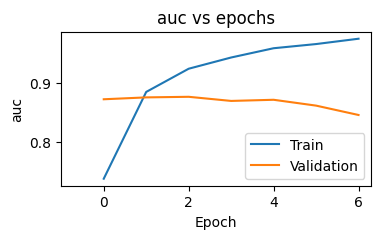

80/80 [==============================] - 0s 2ms/step
Finished in 0
Training:  DL_3layers / tfidf_vectorizer1500
Epoch 1/10
285/285 [==============================] - 2s 5ms/step - loss: 0.4962 - auc: 0.8028 - val_loss: 0.4150 - val_auc: 0.8786
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.3413 - auc: 0.9134 - val_loss: 0.4134 - val_auc: 0.8789
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2908 - auc: 0.9366 - val_loss: 0.4325 - val_auc: 0.8788
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2516 - auc: 0.9526 - val_loss: 0.4778 - val_auc: 0.8666
Epoch 5/10
285/285 [==============================] - 2s 6ms/step - loss: 0.2184 - auc: 0.9642 - val_loss: 0.4989 - val_auc: 0.8702
Epoch 6/10
285/285 [==============================] - 4s 13ms/step - loss: 0.1858 - auc: 0.9728 - val_loss: 0.5413 - val_auc: 0.8663
Epoch 7/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1626 - auc: 0.9790 

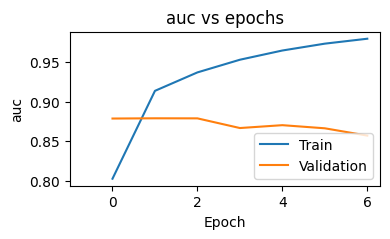

80/80 [==============================] - 0s 898us/step
Finished in 0
Training:  DL_4layers / tfidf_vectorizer1500
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.5086 - auc: 0.7928 - val_loss: 0.4281 - val_auc: 0.8776
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.3504 - auc: 0.9111 - val_loss: 0.4042 - val_auc: 0.8818
Epoch 3/10
285/285 [==============================] - 1s 5ms/step - loss: 0.2903 - auc: 0.9377 - val_loss: 0.4219 - val_auc: 0.8785
Epoch 4/10
285/285 [==============================] - 1s 5ms/step - loss: 0.2430 - auc: 0.9563 - val_loss: 0.4934 - val_auc: 0.8704
Epoch 5/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2014 - auc: 0.9694 - val_loss: 0.5188 - val_auc: 0.8712
Epoch 6/10
285/285 [==============================] - 1s 5ms/step - loss: 0.1702 - auc: 0.9772 - val_loss: 0.5505 - val_auc: 0.8670
Epoch 7/10
285/285 [==============================] - 1s 5ms/step - loss: 0.1470 - auc: 0.9826

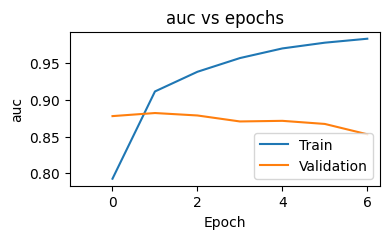

80/80 [==============================] - 0s 5ms/step
Finished in 0
Training:  DL_3layers / tfidf2g_vectorizer1500
Epoch 1/10
285/285 [==============================] - 2s 5ms/step - loss: 0.4943 - auc: 0.8044 - val_loss: 0.4143 - val_auc: 0.8795
Epoch 2/10
285/285 [==============================] - 1s 5ms/step - loss: 0.3387 - auc: 0.9154 - val_loss: 0.4117 - val_auc: 0.8802
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2895 - auc: 0.9387 - val_loss: 0.4272 - val_auc: 0.8773
Epoch 4/10
285/285 [==============================] - 2s 6ms/step - loss: 0.2533 - auc: 0.9519 - val_loss: 0.4642 - val_auc: 0.8685
Epoch 5/10
285/285 [==============================] - 2s 6ms/step - loss: 0.2162 - auc: 0.9639 - val_loss: 0.5053 - val_auc: 0.8670
Epoch 6/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1846 - auc: 0.9728 - val_loss: 0.5492 - val_auc: 0.8665
Epoch 7/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1663 - auc: 0.9778

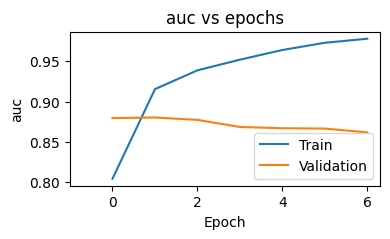

80/80 [==============================] - 0s 1ms/step
Finished in 0
Training:  DL_4layers / tfidf2g_vectorizer1500
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.5014 - auc: 0.7949 - val_loss: 0.4122 - val_auc: 0.8803
Epoch 2/10
285/285 [==============================] - 2s 8ms/step - loss: 0.3427 - auc: 0.9138 - val_loss: 0.4041 - val_auc: 0.8831
Epoch 3/10
285/285 [==============================] - 1s 5ms/step - loss: 0.2857 - auc: 0.9399 - val_loss: 0.4267 - val_auc: 0.8769
Epoch 4/10
285/285 [==============================] - 1s 5ms/step - loss: 0.2427 - auc: 0.9559 - val_loss: 0.4916 - val_auc: 0.8650
Epoch 5/10
285/285 [==============================] - 1s 5ms/step - loss: 0.2006 - auc: 0.9687 - val_loss: 0.5131 - val_auc: 0.8629
Epoch 6/10
285/285 [==============================] - 2s 6ms/step - loss: 0.1713 - auc: 0.9764 - val_loss: 0.6052 - val_auc: 0.8515
Epoch 7/10
285/285 [==============================] - 1s 5ms/step - loss: 0.1505 - auc: 0.9810

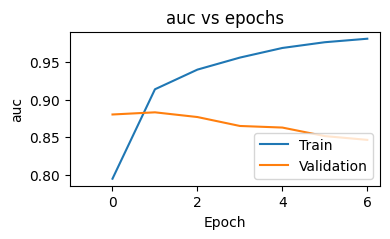

80/80 [==============================] - 0s 2ms/step
Finished in 0
Training:  DL_3layers / bow_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.5293 - auc: 0.7794 - val_loss: 0.4264 - val_auc: 0.8727
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.3563 - auc: 0.9065 - val_loss: 0.4029 - val_auc: 0.8841
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2904 - auc: 0.9382 - val_loss: 0.4308 - val_auc: 0.8795
Epoch 4/10
285/285 [==============================] - 2s 6ms/step - loss: 0.2435 - auc: 0.9559 - val_loss: 0.4736 - val_auc: 0.8716
Epoch 5/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2204 - auc: 0.9627 - val_loss: 0.4858 - val_auc: 0.8745
Epoch 6/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1839 - auc: 0.9732 - val_loss: 0.5508 - val_auc: 0.8659
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1626 - auc: 0.9791 - v

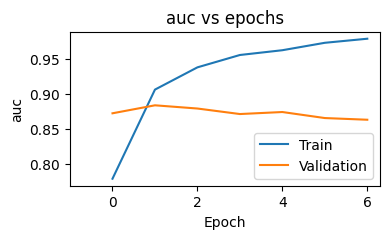

80/80 [==============================] - 0s 2ms/step
Finished in 0
Training:  DL_4layers / bow_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.5693 - auc: 0.7399 - val_loss: 0.4298 - val_auc: 0.8757
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.3732 - auc: 0.8997 - val_loss: 0.4033 - val_auc: 0.8864
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3056 - auc: 0.9316 - val_loss: 0.4419 - val_auc: 0.8782
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2579 - auc: 0.9509 - val_loss: 0.4689 - val_auc: 0.8744
Epoch 5/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2156 - auc: 0.9649 - val_loss: 0.5015 - val_auc: 0.8780
Epoch 6/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1934 - auc: 0.9715 - val_loss: 0.5413 - val_auc: 0.8680
Epoch 7/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1670 - auc: 0.9781 - v

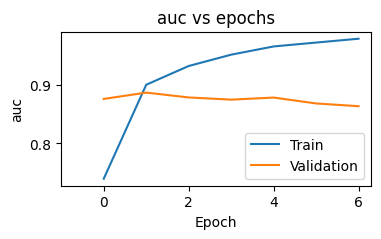

80/80 [==============================] - 0s 3ms/step
Finished in 0
Training:  DL_3layers / tfidf_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 5ms/step - loss: 0.4923 - auc: 0.8060 - val_loss: 0.4038 - val_auc: 0.8810
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3287 - auc: 0.9208 - val_loss: 0.4059 - val_auc: 0.8839
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2672 - auc: 0.9476 - val_loss: 0.4297 - val_auc: 0.8825
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2297 - auc: 0.9602 - val_loss: 0.4661 - val_auc: 0.8768
Epoch 5/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1904 - auc: 0.9717 - val_loss: 0.5080 - val_auc: 0.8743
Epoch 6/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1640 - auc: 0.9783 - val_loss: 0.5449 - val_auc: 0.8716


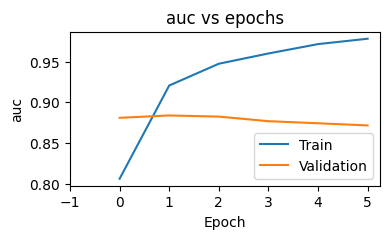

80/80 [==============================] - 0s 2ms/step
Finished in 0
Training:  DL_4layers / tfidf_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.4958 - auc: 0.7992 - val_loss: 0.4135 - val_auc: 0.8855
Epoch 2/10
285/285 [==============================] - 1s 5ms/step - loss: 0.3332 - auc: 0.9188 - val_loss: 0.3979 - val_auc: 0.8883
Epoch 3/10
285/285 [==============================] - 2s 6ms/step - loss: 0.2692 - auc: 0.9466 - val_loss: 0.4246 - val_auc: 0.8832
Epoch 4/10
285/285 [==============================] - 2s 8ms/step - loss: 0.2224 - auc: 0.9619 - val_loss: 0.4860 - val_auc: 0.8756
Epoch 5/10
285/285 [==============================] - 2s 7ms/step - loss: 0.1785 - auc: 0.9742 - val_loss: 0.5169 - val_auc: 0.8745
Epoch 6/10
285/285 [==============================] - 2s 5ms/step - loss: 0.1497 - auc: 0.9818 - val_loss: 0.5917 - val_auc: 0.8655
Epoch 7/10
285/285 [==============================] - 1s 5ms/step - loss: 0.1287 - auc: 0.9862 -

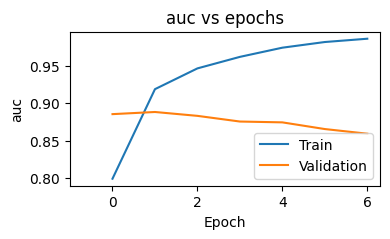

80/80 [==============================] - 0s 2ms/step
Finished in 0
Training:  DL_3layers / tfidf2g_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 5ms/step - loss: 0.4922 - auc: 0.8043 - val_loss: 0.4094 - val_auc: 0.8823
Epoch 2/10
285/285 [==============================] - 1s 5ms/step - loss: 0.3311 - auc: 0.9193 - val_loss: 0.4021 - val_auc: 0.8856
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2689 - auc: 0.9467 - val_loss: 0.4298 - val_auc: 0.8799
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2238 - auc: 0.9628 - val_loss: 0.4758 - val_auc: 0.8747
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1900 - auc: 0.9724 - val_loss: 0.5107 - val_auc: 0.8741
Epoch 6/10
285/285 [==============================] - 1s 5ms/step - loss: 0.1632 - auc: 0.9786 - val_loss: 0.5510 - val_auc: 0.8670
Epoch 7/10
285/285 [==============================] - 1s 5ms/step - loss: 0.1396 - auc: 0.9842

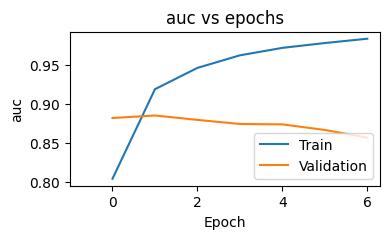

80/80 [==============================] - 0s 3ms/step
Finished in 0
Training:  DL_4layers / tfidf2g_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.4895 - auc: 0.8079 - val_loss: 0.4239 - val_auc: 0.8766
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.3272 - auc: 0.9220 - val_loss: 0.4039 - val_auc: 0.8868
Epoch 3/10
285/285 [==============================] - 2s 6ms/step - loss: 0.2672 - auc: 0.9478 - val_loss: 0.4224 - val_auc: 0.8815
Epoch 4/10
285/285 [==============================] - 1s 5ms/step - loss: 0.2122 - auc: 0.9661 - val_loss: 0.5157 - val_auc: 0.8686
Epoch 5/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1698 - auc: 0.9771 - val_loss: 0.5510 - val_auc: 0.8663
Epoch 6/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1454 - auc: 0.9829 - val_loss: 0.6371 - val_auc: 0.8593
Epoch 7/10
285/285 [==============================] - 2s 6ms/step - loss: 0.1253 - auc: 0.9867

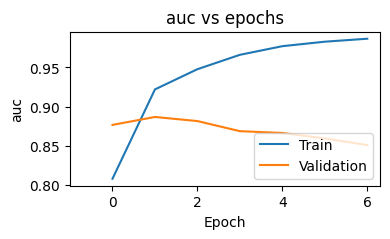

80/80 [==============================] - 0s 2ms/step
Finished in 0
CPU times: total: 34min 17s
Wall time: 4min 27s


In [231]:
%%time
vectorizer_list = [bow_vectorizer, tfidf_vectorizer, tfidf2g_vectorizer]
n_features = [500,800, 1000, 1500, 2000]

models = [
    ('DL_3layers',(128,64,32), (0.5,0.2,0.1)), # model name, neurons, dropout
    ('DL_4layers', (256,128,64,32), (0.5,0.5,0.2,0.1))
]


# loop through the range of n_feature
for n_feature in n_features:
    # loop through the vectorizer
    for vectorizer in vectorizer_list:
        X_train_vectorized, X_test_vectorized = vectorizer(X_train, X_test, n_feature)
        X_train_vectorized = np.array(X_train_vectorized)
        X_test_vectorized = np.array(X_test_vectorized)
        # loop through the baseline DL models
        for model_name, neurons, dropouts in models:
            print(f'Training:  {model_name} / {vectorizer.__name__+str(n_feature)}')
            start = time.time()
            dl_model = make_DL_model(neurons, dropouts, input_dim = n_feature)
            history = dl_model.fit(X_train_vectorized, y_train, 
                                batch_size=32,
                                epochs=10,
                                callbacks=[callback],
                                verbose=1,
                                validation_split = 0.1)
            completion_time = round(time.time() - start,2)
            accuracy_vs_epochs(history)
            dl_performance(model_name, dl_model, vectorizer.__name__+str(n_feature), 
                           X_train_vectorized, X_test_vectorized, y_train, y_test)

In [233]:
df_metrics[summary2]

,model name,data,time,train_acc,test_acc,test_up_F1,test_down_F1
0,DL_3layers,bow_vectorizer500,0,0.85,0.82,0.87,0.70
1,DL_4layers,bow_vectorizer500,0,0.86,0.83,0.87,0.71
2,DL_3layers,tfidf_vectorizer500,0,0.86,0.83,0.87,0.72
3,DL_4layers,tfidf_vectorizer500,0,0.86,0.82,0.87,0.72
4,DL_3layers,tfidf2g_vectorizer500,0,0.85,0.82,0.87,0.72
5,DL_4layers,tfidf2g_vectorizer500,0,0.87,0.82,0.87,0.71
6,DL_3layers,bow_vectorizer800,0,0.88,0.83,0.88,0.74
7,DL_4layers,bow_vectorizer800,0,0.87,0.83,0.88,0.74
8,DL_3layers,tfidf_vectorizer800,0,0.88,0.83,0.88,0.73
9,DL_4layers,tfidf_vectorizer800,0,0.88,0.83,0.88,0.73


In [246]:
df_metrics_combined = pd.concat([df_metrics, df_metrics_nonDL]).reset_index()
df_metrics_combined['preprocessed'] = df_metrics_combined.data.str.split('_').apply(lambda x: x[0])
df_metrics_combined['feature_size'] = df_metrics_combined.data.str.split('_').apply(lambda x: x[-1][10:])

In [247]:
df_metrics_combined

,level_0,model name,data,time,train_down_Pre,train_down_Rec,train_down_F1,train_up_Pre,train_up_Rec,train_up_F1,...,test_down_Pre,test_down_Rec,test_down_F1,test_up_Pre,test_up_Rec,test_up_F1,test_acc,preprocessed,feature_size,index
0,0,DL_3layers,bow_vectorizer500,0.00,0.84,0.69,0.76,0.86,0.94,0.89,...,0.79,0.63,0.70,0.83,0.92,0.87,0.82,bow,500,NaN
1,1,DL_4layers,bow_vectorizer500,0.00,0.85,0.72,0.78,0.87,0.93,0.90,...,0.78,0.66,0.71,0.84,0.91,0.87,0.83,bow,500,NaN
2,2,DL_3layers,tfidf_vectorizer500,0.00,0.82,0.72,0.77,0.87,0.92,0.90,...,0.78,0.68,0.72,0.85,0.90,0.87,0.83,tfidf,500,NaN
3,3,DL_4layers,tfidf_vectorizer500,0.00,0.81,0.75,0.78,0.88,0.91,0.89,...,0.76,0.69,0.72,0.85,0.89,0.87,0.82,tfidf,500,NaN
4,4,DL_3layers,tfidf2g_vectorizer500,0.00,0.80,0.73,0.76,0.87,0.91,0.89,...,0.76,0.69,0.72,0.85,0.89,0.87,0.82,tfidf2g,500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,55,XGB_classifier,tfidf_vectorizer2000,8.55,0.95,0.73,0.83,0.88,0.98,0.93,...,0.84,0.61,0.71,0.83,0.94,0.88,0.83,tfidf,2000,70.00
86,56,NB_classifier,tfidf2g_vectorizer2000,0.12,0.87,0.64,0.74,0.84,0.95,0.89,...,0.86,0.62,0.72,0.83,0.95,0.89,0.84,tfidf2g,2000,71.00
87,57,LG_classifier,tfidf2g_vectorizer2000,0.90,0.89,0.71,0.79,0.87,0.96,0.91,...,0.85,0.68,0.75,0.85,0.94,0.90,0.85,tfidf2g,2000,72.00
88,58,RF_classifier,tfidf2g_vectorizer2000,25.84,0.99,0.93,0.96,0.97,1.00,0.98,...,0.79,0.65,0.71,0.84,0.92,0.88,0.83,tfidf2g,2000,73.00


### Compare DL models to baseline classification models

#### Accuracy on test set, by model

<Axes: xlabel='model name', ylabel='test_acc'>

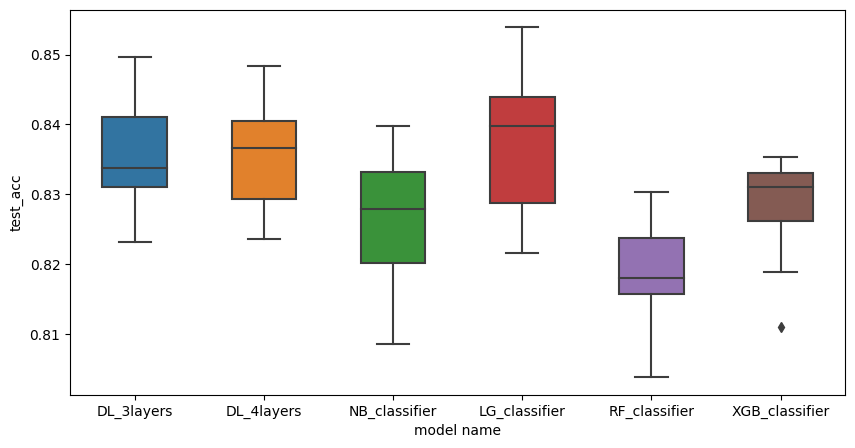

In [248]:
plt.figure(figsize = (10,5))
sns.boxplot(data=df_metrics_combined, x='model name', y='test_acc', width=0.5)

#### F1 score for negative on test set, by model

<Axes: xlabel='model name', ylabel='test_down_F1'>

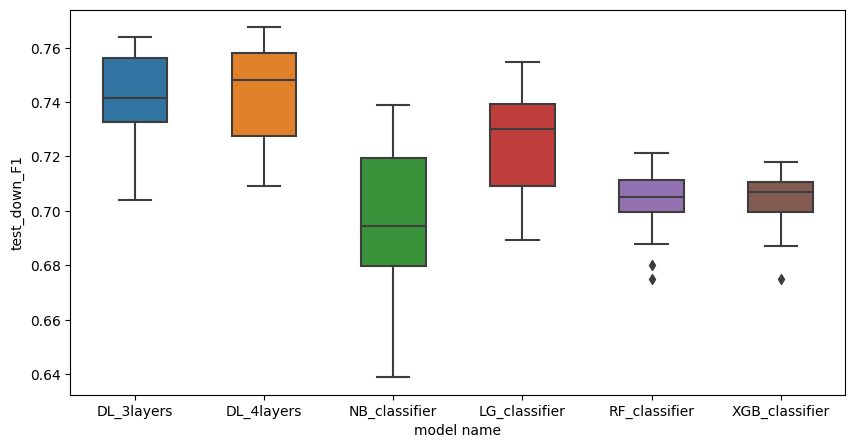

In [249]:
plt.figure(figsize = (10,5))
sns.boxplot(data=df_metrics_combined, x='model name', y='test_down_F1', width=0.5)

- While accuracy of DL on test set is not significanty higher than baseline models, F1 score is a lot better.

#### F1 score for negative on test set, by model AND preprocess

<Axes: xlabel='model name', ylabel='test_down_F1'>

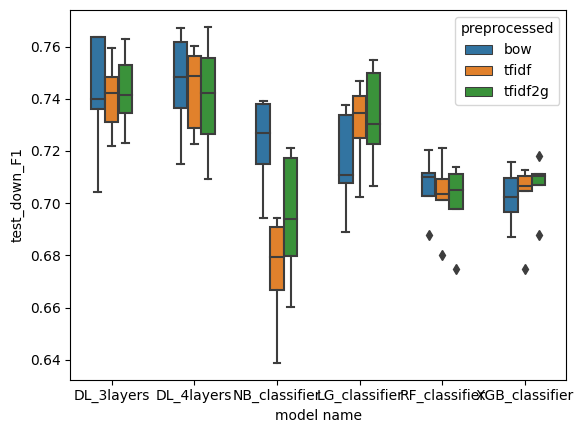

In [250]:
sns.boxplot(data=df_metrics_combined, x='model name', y='test_down_F1', hue='preprocessed', width=0.5)

#### F1 score for negative on test set, by model AND feature size

<Axes: xlabel='model name', ylabel='test_down_F1'>

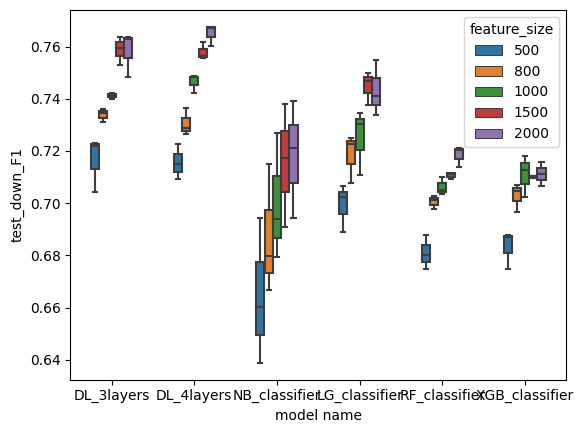

In [251]:
sns.boxplot(data=df_metrics_combined, x='model name', y='test_down_F1', hue='feature_size', width=0.5)

### Time of completion

#### Time of completion by model

<Axes: xlabel='model name', ylabel='time'>

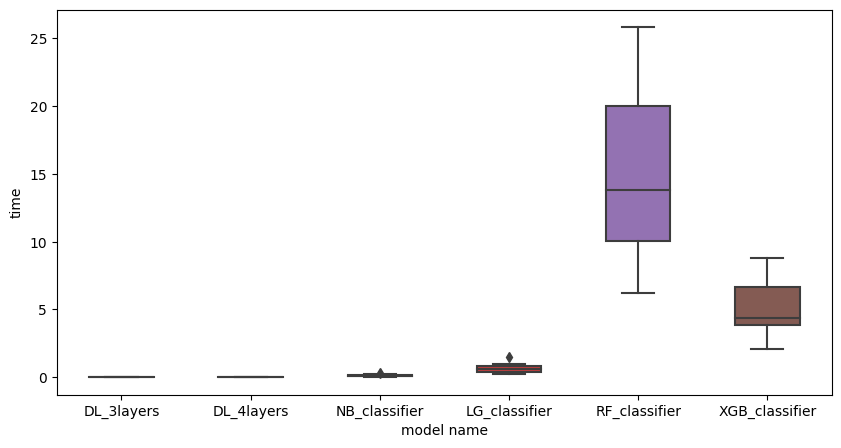

In [252]:
plt.figure(figsize = (10,5))
sns.boxplot(data=df_metrics_combined, x='model name', y='time', width=0.5)

#### Time of completion by model AND preprocess

<Axes: xlabel='model name', ylabel='time'>

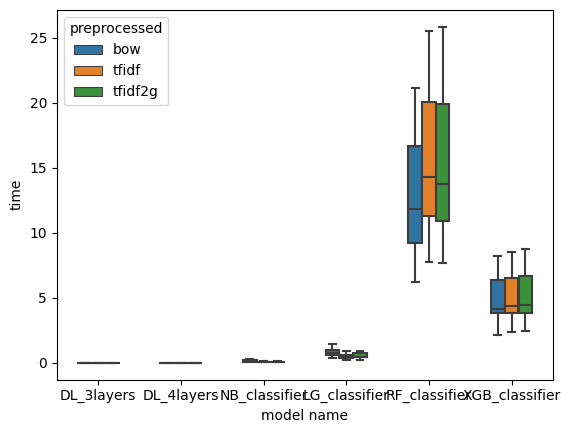

In [253]:
sns.boxplot(data=df_metrics_combined, x='model name', y='time', hue='preprocessed', width=0.5)

#### Time of completion by model AND feature size

<Axes: xlabel='model name', ylabel='time'>

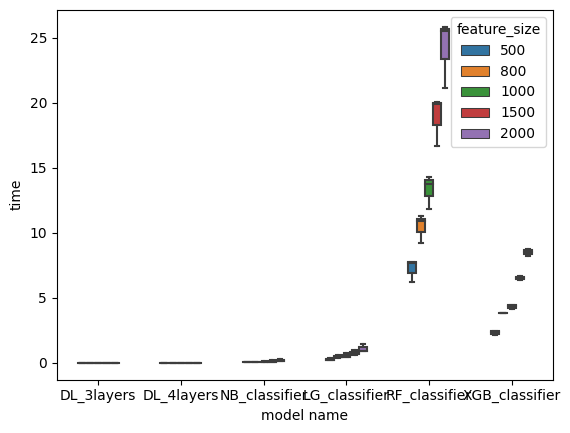

In [254]:
sns.boxplot(data=df_metrics_combined, x='model name', y='time', hue='feature_size', width=0.5)

# 7. Conclusion